In [22]:
import pandas as pd

### Preprocess

In [23]:
# df = pd.read_excel('IPO_stocks.xlsx')
# df1 = pd.read_excel('IPO_stocks - akash.xlsx') #.dropna()
# df2 = pd.read_excel('IPO_stocks - haikal.xlsx') #.dropna()
# df2 = df2.loc[df2['Code'] != 'ORGABIO HOLDINGS BERHAD'].copy()

# fdf = df.loc[:, "Code":"20d_ret"].set_index('Code').copy()
# df1_ = df1[['Code', 'Oversubscription_Rate', 'Total_Applicants', 'Bumiputera_Applicants', 'Bumiputera_Oversubscription_Rate', 'Public_Applicants', 'Public_Oversubscription_Rate']].set_index('Code').copy()
# df2_ = df2[['Code', 'Oversubscription_Rate', 'Total_Applicants', 'Bumiputera_Applicants', 'Bumiputera_Oversubscription_Rate', 'Public_Applicants', 'Public_Oversubscription_Rate']].set_index('Code').copy()

# cols = ['Oversubscription_Rate', 'Total_Applicants', 'Bumiputera_Applicants', 'Bumiputera_Oversubscription_Rate', 'Public_Applicants', 'Public_Oversubscription_Rate']
# for j in cols:
#     fdf[j] = df1_[j]
#     fdf[j] = fdf[j].fillna(df2_[j])
# fdf.to_excel('IPO_2.xlsx')


# READ PREPROCESSED DATA

In [24]:
sector_df = pd.read_excel("mk_sector.xlsx")
fdf = pd.read_excel("IPO_2.xlsx")
fdf['Code'] = fdf['Code'].apply(lambda x: str(x).zfill(4))
sector_df['Code'] = sector_df['ID_ISIN'].apply(lambda x: str(x)[3:7])
fdf = pd.merge(fdf, sector_df[['Code', 'EXCH_MKT_GRP', 'GICS_SECTOR_NAME']], left_on="Code", right_on="Code", how="left")

In [34]:
fdf['IPO_Price'] = fdf['Close'] - fdf['PriceChange1']
fdf['Open_Ret'] = fdf['Open']/fdf['IPO_Price'] - 1
fdf['Close_Open'] = fdf['Close'] - fdf['Open']

In [35]:
sector_df.columns

Index(['ID', 'NAME', 'cur_mkt_cap().value', 'security_typ().value',
       'ID_SEDOL1', 'ID_ISIN', 'EXCH_MKT_GRP', 'FINANCIAL_STATUS_INDICATOR',
       'IS_ISLAMIC', 'GICS_SECTOR_NAME', 'GICS_SUB_INDUSTRY_NAME',
       'LAST_UPDATE_DT', 'Code'],
      dtype='object')

In [36]:
# fdf2['GICS_SECTOR_NAME'].unique()

In [78]:
cols = ['Code', 'Date', 'Stock', 'StockLongName', 'Open', 'Close',
       'PriceChange1', 'PctChange1', 'Open_Ret', 'Close_Open', 'Volume', 'NumShares', '20d_ret', 'EXCH_MKT_GRP', 'GICS_SECTOR_NAME',
       'Oversubscription_Rate', 'Total_Applicants']
fdf.shape
fdf2 = fdf[cols].sort_values("Date").copy()
# fdf['GICS_SECTOR_NAME'].unique()

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', drop='first')
X = fdf2[['EXCH_MKT_GRP', 'GICS_SECTOR_NAME']]
enc.fit(X)
new_feats = enc.transform(X).toarray()

xcols = ['Oversubscription_Rate', 'Total_Applicants']
for j in range(new_feats.shape[1]):
    fdf2[f"C{j}"] = new_feats[:, j].astype(int)
    xcols += [f"C{j}"]
u1 = fdf2[['Total_Applicants', 'Oversubscription_Rate']].isna().mean(axis=1) ==  0
fdf3 = fdf2.loc[u1].copy()
# fdf3

In [62]:
# test_df = fdf2.iloc[:1].copy()
# test_df['Oversubscription_Rate'] = 5.28
# test_df['Total_Applicants'] = 2603
# test_df['EXCH_MKT_GRP'] = 'MAIN'
# test_df['GICS_SECTOR_NAME'] = 'Consumer Discretionary'

# new_feats_test = enc.transform(test_df[['EXCH_MKT_GRP', 'GICS_SECTOR_NAME']]).toarray()
# for j in range(new_feats_test.shape[1]):
#     test_df[f"C{j}"] = new_feats_test[:, j].astype(int)
# test_df


In [79]:
pd.set_option('display.max_columns', 50)
# fdf3['20d_ret'].isna().sum()

In [106]:
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.ensemble import RandomForestRegressor

xcols = ['Oversubscription_Rate',
 'Total_Applicants',
 'C0',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9']
         
xcols = ['Oversubscription_Rate','Total_Applicants','C0']
xcols = ['Oversubscription_Rate','Total_Applicants',]
# xcols = ['Oversubscription_Rate',]
# xcols = ['Total_Applicants',]
model = HuberRegressor()
# model = LinearRegression()
# model = RandomForestRegressor()
X= fdf3[xcols]
# y= fdf2['PctChange1']
# y = fdf3['20d_ret']
y = fdf3['Open_Ret']
# y = fdf2['Close_Open']

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)
print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

model.fit(X_train,y_train)
y_pred_train = model.predict(X_train)

# Make predictions on the validation set
y_pred = model.predict(X_test)

# Compute the mean squared error (MSE) on the validation set
mse = mean_absolute_error(y_test, y_pred)

# Print the validation error
print("Validation MAE:",mse)
display(test_df[xcols])
try:
    print(model.predict(test_df[xcols]),model.coef_, model.intercept_)
except:
    print(model.predict(test_df[xcols]), model.feature_importances_)


Training set size: 85
Testing set size: 37
Validation MAE: 0.2847932183513221


,Oversubscription_Rate,Total_Applicants
43,5.28,2603


[0.04155238] [1.00260217e-02 5.51664576e-06] -0.02574484487768551


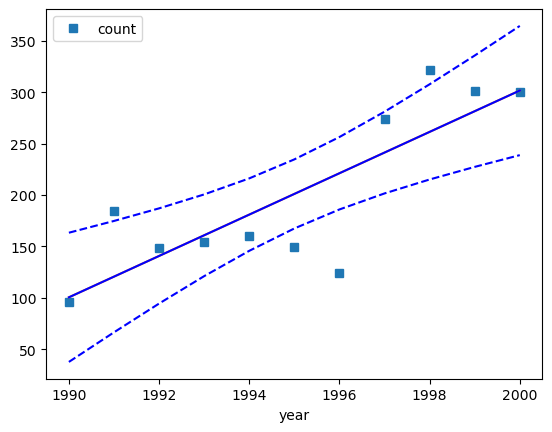

In [155]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

df = pd.DataFrame({'year':['1990','1991','1992','1993','1994','1995','1996','1997','1998','1999','2000'],
                   'count':[96,184,148,154,160,149,124,274,322,301,300]})
df['year'] = df['year'].astype(float)
X = sm.add_constant(df['year'].values)
ols_model = sm.OLS(df['count'].values, X)
est = ols_model.fit()
out = est.conf_int(alpha=0.05, cols=None)

fig, ax = plt.subplots()
df.plot(x='year',y='count',linestyle='None',marker='s', ax=ax)
y_pred = est.predict(X)
x_pred = df.year.values
ax.plot(x_pred,y_pred)

pred = est.get_prediction(X).summary_frame()
ax.plot(x_pred,pred['mean_ci_lower'],linestyle='--',color='blue')
ax.plot(x_pred,pred['mean_ci_upper'],linestyle='--',color='blue')

# Alternative way to plot
def line(x,b=0,m=1):
    return m*x+b

ax.plot(x_pred,line(x_pred,est.params[0],est.params[1]),color='blue')

In [163]:
pred

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,100.454545,27.796691,37.574062,163.335028,-27.532451,228.441542
1,120.581818,23.957734,66.385658,174.777979,-3.369543,244.533180
2,140.709091,20.480279,94.379481,187.038701,19.989793,261.428389
3,160.836364,17.580171,121.067254,200.605473,42.479707,279.193020
4,180.963636,15.583156,145.712089,216.215184,64.047479,297.879793
5,201.090909,14.857956,167.479877,234.701941,84.658879,317.522939
6,221.218182,15.583156,185.966634,256.469730,104.302025,338.134339
7,241.345455,17.580171,201.576345,281.114564,122.988798,359.702111
8,261.472727,20.480279,215.143117,307.802338,140.753429,382.192025
9,281.600000,23.957734,227.403839,335.796161,157.648639,405.551361


In [ ]:
stdev = np.sqrt(sum((classifier.predict(X_train) - y_train)**2) / (len(y_train) - 2))


prediction = (y_pred - 1.96*stdev, y_pred + 1.96*stdev)

In [154]:
from scipy import stats
import numpy as np
x = np.random.random(10)
y = np.random.random(10)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

confidence_interval = 2.58*std_err
confidence_interval

1.0605719726570444

In [141]:
x1.shape, y1.shape

((122, 2), (122,))

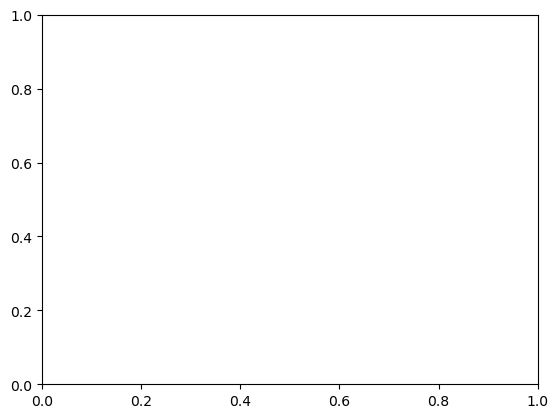

In [169]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

df = pd.DataFrame({'year':['1990','1991','1992','1993','1994','1995','1996','1997','1998','1999','2000'],
                   'count':[96,184,148,154,160,149,124,274,322,301,300]})
df['year'] = df['year'].astype(float)
# x1 = df['year'].values
# y1 = df['count'].values

x1 = fdf3[xcols].values
y1 = fdf3['Open_Ret'].values
y1 = fdf3['PctChange1'].values

X = sm.add_constant(x1)
ols_model = sm.OLS(y1, X)
est = ols_model.fit()
out = est.conf_int(alpha=0.05, cols=None)

fig, ax = plt.subplots()
# df.plot(x='year',y='count',linestyle='None',marker='s', ax=ax)
y_pred = est.predict(X)
x_pred = x1
# ax.plot(x_pred,y_pred)

pred = est.get_prediction(X).summary_frame()
# ax.plot(x_pred,pred['mean_ci_lower'],linestyle='--',color='blue')
# ax.plot(x_pred,pred['mean_ci_upper'],linestyle='--',color='blue')

# Alternative way to plot
def line(x,b=0,m=1):
    return m*x+b

# ax.plot(x_pred,line(x_pred,est.params[0],est.params[1]),color='blue')


In [170]:
pred['actual'] = y1
pred

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,actual
0,0.482915,0.050716,0.382492,0.583338,-0.585296,1.551125,1.133333
1,0.164718,0.065546,0.034930,0.294506,-0.906653,1.236088,-0.250000
2,0.153001,0.058647,0.036874,0.269128,-0.916800,1.222802,0.261538
3,0.127502,0.060401,0.007901,0.247102,-0.942682,1.197685,0.063636
4,0.186235,0.055918,0.075512,0.296959,-0.882993,1.255464,0.204225
...,...,...,...,...,...,...,...
117,1.237064,0.145045,0.949860,1.524269,0.135486,2.338643,0.355263
118,0.248962,0.059848,0.130457,0.367466,-0.821100,1.319023,-0.186047
119,1.484084,0.163321,1.160693,1.807476,0.372522,2.595647,2.041667
120,0.037441,0.069643,-0.100460,0.175341,-1.034942,1.109824,-0.075000


In [171]:
pred

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,actual
0,0.482915,0.050716,0.382492,0.583338,-0.585296,1.551125,1.133333
1,0.164718,0.065546,0.034930,0.294506,-0.906653,1.236088,-0.250000
2,0.153001,0.058647,0.036874,0.269128,-0.916800,1.222802,0.261538
3,0.127502,0.060401,0.007901,0.247102,-0.942682,1.197685,0.063636
4,0.186235,0.055918,0.075512,0.296959,-0.882993,1.255464,0.204225
...,...,...,...,...,...,...,...
117,1.237064,0.145045,0.949860,1.524269,0.135486,2.338643,0.355263
118,0.248962,0.059848,0.130457,0.367466,-0.821100,1.319023,-0.186047
119,1.484084,0.163321,1.160693,1.807476,0.372522,2.595647,2.041667
120,0.037441,0.069643,-0.100460,0.175341,-1.034942,1.109824,-0.075000


In [134]:
est.get_prediction(X).summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,100.454545,27.796691,37.574062,163.335028,-27.532451,228.441542
1,120.581818,23.957734,66.385658,174.777979,-3.369543,244.533180
2,140.709091,20.480279,94.379481,187.038701,19.989793,261.428389
3,160.836364,17.580171,121.067254,200.605473,42.479707,279.193020
4,180.963636,15.583156,145.712089,216.215184,64.047479,297.879793
5,201.090909,14.857956,167.479877,234.701941,84.658879,317.522939
6,221.218182,15.583156,185.966634,256.469730,104.302025,338.134339
7,241.345455,17.580171,201.576345,281.114564,122.988798,359.702111
8,261.472727,20.480279,215.143117,307.802338,140.753429,382.192025
9,281.600000,23.957734,227.403839,335.796161,157.648639,405.551361


In [130]:
est.params[0]

-39952.81818181659

In [125]:
y_train

36     0.161765
75     0.500000
22     0.300000
107    0.035714
78     0.400000
         ...   
92     0.246154
125    0.577778
9      0.081250
20     0.289474
117    0.036765
Name: Open_Ret, Length: 85, dtype: float64

In [118]:
# y

In [116]:
res.conf_int(0.01)   # 99% confidence interval


array([[ 0.34306309,  1.82685049],
       [-0.14943892,  0.53633099],
       [ 9.95724053, 10.02359867]])

In [114]:
res.conf_int(

In [112]:
# !pip install statsmodels

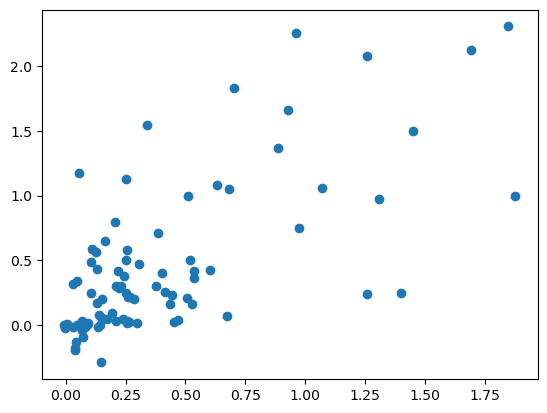

In [107]:
import matplotlib.pyplot as plt
plt.scatter(y_pred_train, y_train)

In [108]:
(y_pred_train-y_train).quantile(0.05),(y_pred_train-y_train).quantile(0.95)


(-0.8672259635514201, 0.431869337675425)

In [17]:
# from sklearn.linear_model import HuberRegressor, LinearRegression, LogisticRegression
# from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# xcols = ['Oversubscription_Rate',
#  'Total_Applicants',
#  'C0',
#  'C1',
#  'C2',
#  'C3',
#  'C4',
#  'C5',
#  'C6',
#  'C7',
#  'C8',
#  'C9']
         
# xcols = ['Oversubscription_Rate','Total_Applicants','C0', 'Open_Ret']
# model = HuberRegressor()
# # model = LinearRegression()
# model = RandomForestRegressor()
# model = LogisticRegression()
# model  =RandomForestClassifier()
# X= fdf2[xcols]
# # y= fdf2['PctChange1']
# # y = fdf2['20d_ret']
# # y = fdf2['Open_Ret']
# y = 1*(fdf2['Close_Open'] > 0)

# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)
# print("Training set size:", len(X_train))
# print("Testing set size:", len(X_test))


# model.fit(X_train,y_train)
# # Make predictions on the validation set
# y_pred = model.predict(X_test)

# # Compute the mean squared error (MSE) on the validation set
# mse = mean_absolute_error(y_test, y_pred)

# # Print the validation error
# print("Validation MAE:",mse)



# try:
#     print(model.predict(test_df[xcols]),model.coef_, model.intercept_)
# except:
#     print(model.predict(test_df[xcols]), model.feature_importances_)


In [331]:
# pd.DataFrame({"yp": y_pred, "yval": y_test}).plot.scatter(x="yp", y="yval")

In [339]:
model = RandomForestRegressor()
X= fdf2[xcols]
y= fdf2['PctChange1']
y = fdf2['20d_ret']
model.fit(X,y)

# model.coef_, model.intercept_
model.predict(test_df[xcols]), model.feature_importances_


(array([0.04340675]), array([0.57573537, 0.39106491, 0.03319972]))

In [342]:
# fdf2.plot.scatter(x="Oversubscription_Rate", y="PctChange1")
# fdf2.plot.scatter(x="Oversubscription_Rate", y="Open_Ret")
# fdf2.plot.scatter(x="Oversubscription_Rate", y="Close_Open")

In [401]:
df = fdf2.query('C0==1')
# df = fdf2

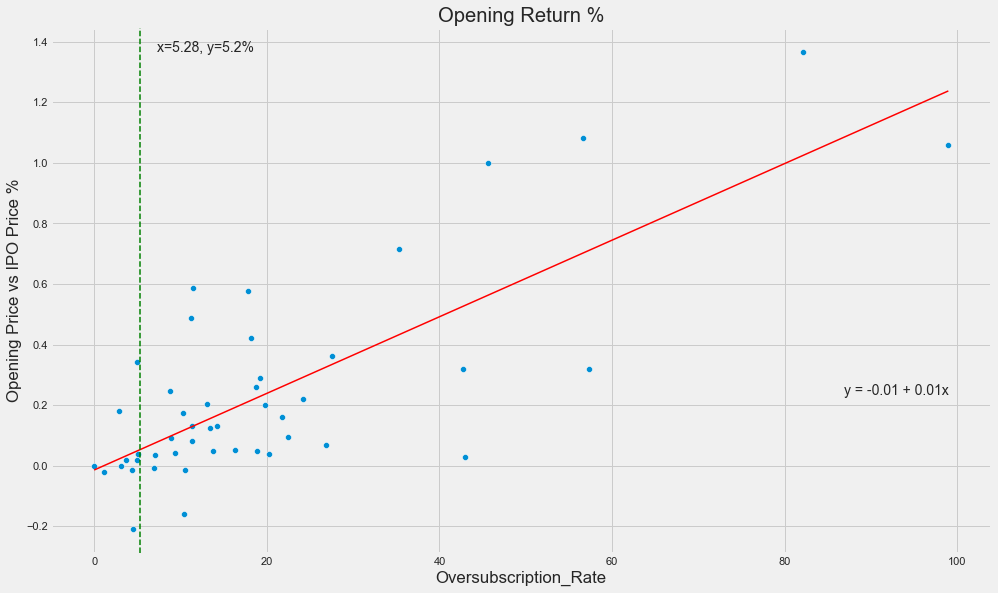

In [405]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

# Assuming you have a pandas DataFrame called 'df' with columns 'x' and 'y'
# sns.set(style='ticks', palette='colorblind')
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 9))
xcol = 'Oversubscription_Rate'
ycol ="Open_Ret"
ycol_ = "Opening Price vs IPO Price %"
# Scatterplot
sns.scatterplot(data=df, x=xcol, y=ycol)

# Regression line
model = sm.OLS(df[ycol], sm.add_constant(df[xcol])).fit()
x_values = np.linspace(df[xcol].min(), df[xcol].max(), 100)
y_values = model.predict(sm.add_constant(x_values))
plt.plot(x_values, y_values, color='red', linewidth=1.5)

# Annotation
reg_eq = f'y = {model.params[0]:.2f} + {model.params[1]:.2f}x'
# plt.annotate(reg_eq, xy=(0.05, 0.95), xycoords='axes fraction')
plt.text(df[xcol].max(), df[ycol].mean(), reg_eq, ha='right')

# Highlight value at x=5
# Highlight value at x=5 with a vertical line
highlight_x = 5.28
highlight_y = model.params[0] + model.params[1] * highlight_x
plt.axvline(x=highlight_x, linestyle='--', color='green', zorder=10, linewidth=1.5)
highlight_annotation = f'x={highlight_x}, y={highlight_y:.1%}'
plt.text(highlight_x+2, df[ycol].max(), highlight_annotation, ha='left')

# Labels and title
plt.xlabel(xcol)

plt.ylabel(ycol_)
plt.title('Opening Return %')

# Show the plot
plt.show()

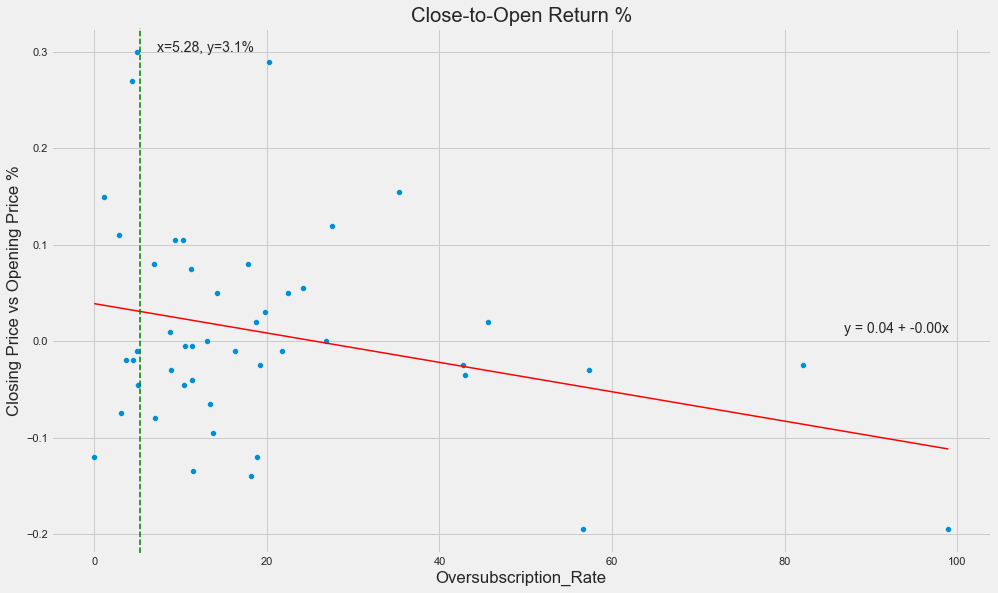

In [407]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

# Assuming you have a pandas DataFrame called 'df' with columns 'x' and 'y'
# sns.set(style='ticks', palette='colorblind')
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 9))
xcol = 'Oversubscription_Rate'
ycol ="Close_Open"
ycol_ = "Closing Price vs Opening Price %"
# Scatterplot
sns.scatterplot(data=df, x=xcol, y=ycol)

# Regression line
model = sm.OLS(df[ycol], sm.add_constant(df[xcol])).fit()
x_values = np.linspace(df[xcol].min(), df[xcol].max(), 100)
y_values = model.predict(sm.add_constant(x_values))
plt.plot(x_values, y_values, color='red', linewidth=1.5)

# Annotation
reg_eq = f'y = {model.params[0]:.2f} + {model.params[1]:.2f}x'
# plt.annotate(reg_eq, xy=(0.05, 0.95), xycoords='axes fraction')
plt.text(df[xcol].max(), df[ycol].mean(), reg_eq, ha='right')

# Highlight value at x=5
# Highlight value at x=5 with a vertical line
highlight_x = 5.28
highlight_y = model.params[0] + model.params[1] * highlight_x
plt.axvline(x=highlight_x, linestyle='--', color='green', zorder=10, linewidth=1.5)
highlight_annotation = f'x={highlight_x}, y={highlight_y:.1%}'
plt.text(highlight_x+2, df[ycol].max(), highlight_annotation, ha='left')

# Labels and title
plt.xlabel(xcol)

plt.ylabel(ycol_)
plt.title('Close-to-Open Return %')

# Show the plot
plt.show()

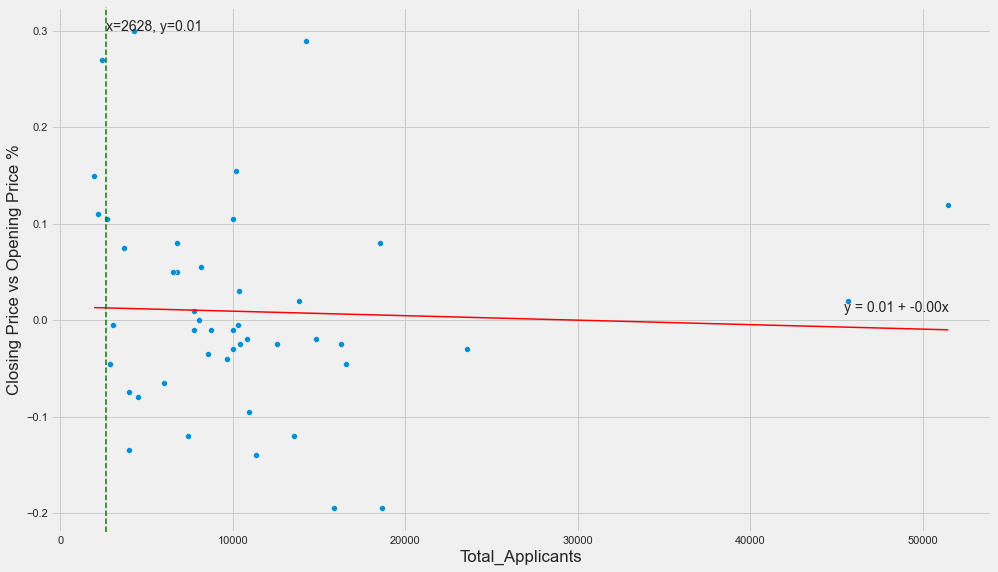

In [397]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

# Assuming you have a pandas DataFrame called 'df' with columns 'x' and 'y'
# sns.set(style='ticks', palette='colorblind')
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 9))
xcol = 'Total_Applicants'
ycol ="Close_Open"
ycol_ = "Closing Price vs Opening Price %"
# Scatterplot
sns.scatterplot(data=df, x=xcol, y=ycol)

# Regression line
model = sm.OLS(df[ycol], sm.add_constant(df[xcol])).fit()
x_values = np.linspace(df[xcol].min(), df[xcol].max(), 100)
y_values = model.predict(sm.add_constant(x_values))
plt.plot(x_values, y_values, color='red', linewidth=1.5)

# Annotation
reg_eq = f'y = {model.params[0]:.2f} + {model.params[1]:.2f}x'
# plt.annotate(reg_eq, xy=(0.05, 0.95), xycoords='axes fraction')
plt.text(df[xcol].max(), df[ycol].mean(), reg_eq, ha='right')

# Highlight value at x=5
# Highlight value at x=5 with a vertical line
highlight_x = 2628
highlight_y = model.params[0] + model.params[1] * highlight_x
plt.axvline(x=highlight_x, linestyle='--', color='green', zorder=10, linewidth=1.5)
highlight_annotation = f'x={highlight_x}, y={highlight_y:.2f}'
plt.text(highlight_x+2, df[ycol].max(), highlight_annotation, ha='left')

# Labels and title
plt.xlabel(xcol)

plt.ylabel(ycol_)
# plt.title('Scatterplot with Regression Line')

# Show the plot
plt.show()

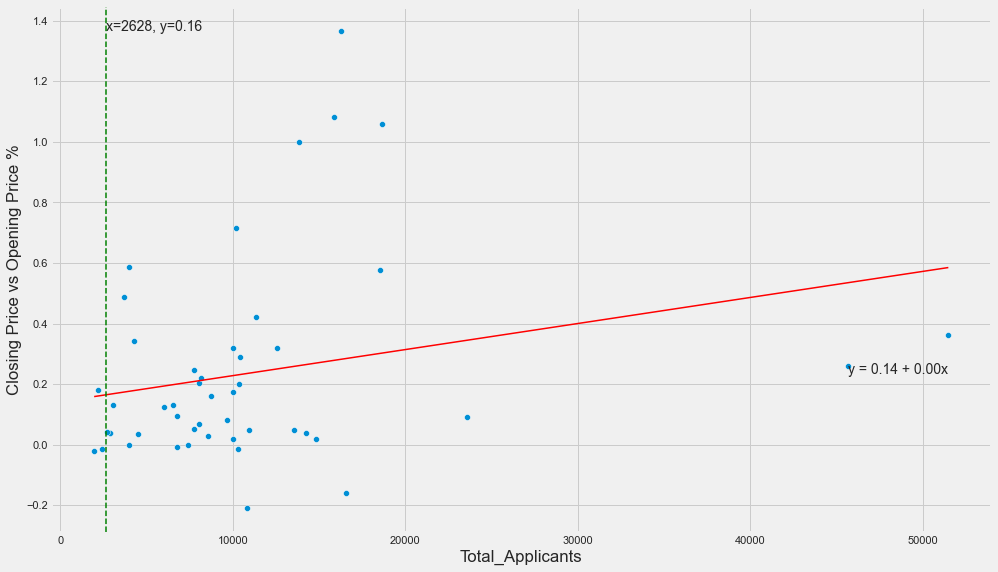

In [398]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

# Assuming you have a pandas DataFrame called 'df' with columns 'x' and 'y'
# sns.set(style='ticks', palette='colorblind')
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 9))
xcol = 'Total_Applicants'
ycol ="Open_Ret"
ycol_ = "Closing Price vs Opening Price %"
# Scatterplot
sns.scatterplot(data=df, x=xcol, y=ycol)

# Regression line
model = sm.OLS(df[ycol], sm.add_constant(df[xcol])).fit()
x_values = np.linspace(df[xcol].min(), df[xcol].max(), 100)
y_values = model.predict(sm.add_constant(x_values))
plt.plot(x_values, y_values, color='red', linewidth=1.5)

# Annotation
reg_eq = f'y = {model.params[0]:.2f} + {model.params[1]:.2f}x'
# plt.annotate(reg_eq, xy=(0.05, 0.95), xycoords='axes fraction')
plt.text(df[xcol].max(), df[ycol].mean(), reg_eq, ha='right')

# Highlight value at x=5
# Highlight value at x=5 with a vertical line
highlight_x = 2628
highlight_y = model.params[0] + model.params[1] * highlight_x
plt.axvline(x=highlight_x, linestyle='--', color='green', zorder=10, linewidth=1.5)
highlight_annotation = f'x={highlight_x}, y={highlight_y:.2f}'
plt.text(highlight_x+2, df[ycol].max(), highlight_annotation, ha='left')

# Labels and title
plt.xlabel(xcol)

plt.ylabel(ycol_)
# plt.title('Scatterplot with Regression Line')

# Show the plot
plt.show()

<AxesSubplot:xlabel='Oversubscription_Rate', ylabel='Close_Open'>

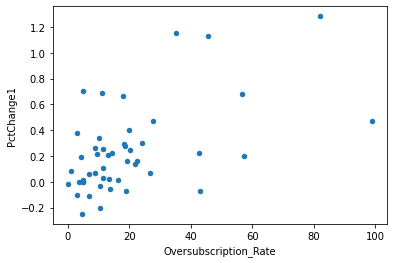

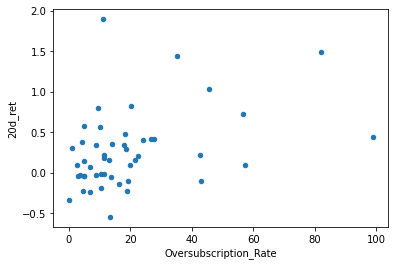

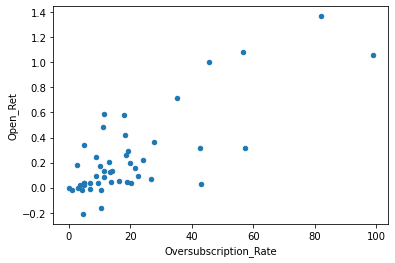

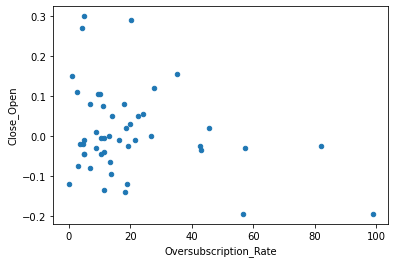

In [343]:
fdf2.query('C0==1').plot.scatter(x="Oversubscription_Rate", y="PctChange1")
fdf2.query('C0==1').plot.scatter(x="Oversubscription_Rate", y="20d_ret")
fdf2.query('C0==1').plot.scatter(x="Oversubscription_Rate", y="Open_Ret")
fdf2.query('C0==1').plot.scatter(x="Oversubscription_Rate", y="Close_Open")



<AxesSubplot:xlabel='Total_Applicants', ylabel='Close_Open'>

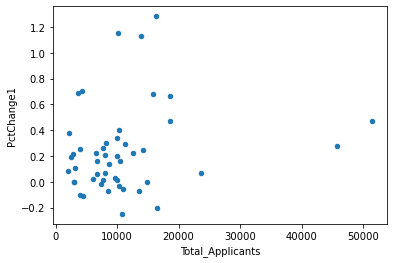

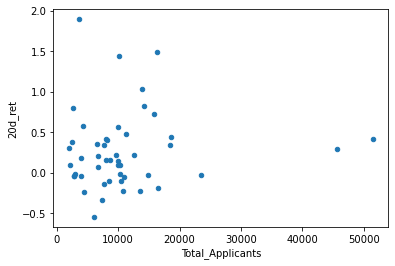

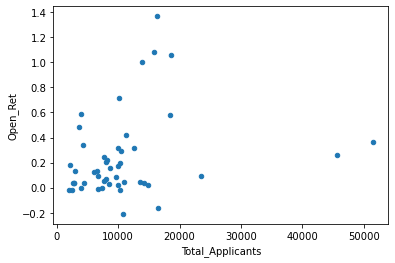

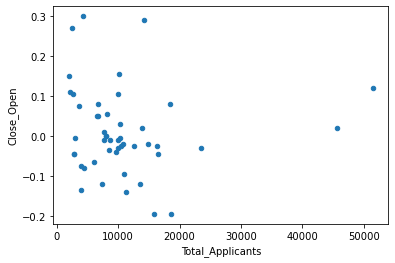

In [344]:
fdf2.query('C0==1').plot.scatter(x="Total_Applicants", y="PctChange1")
fdf2.query('C0==1').plot.scatter(x="Total_Applicants", y="20d_ret")
fdf2.query('C0==1').plot.scatter(x="Total_Applicants", y="Open_Ret")
fdf2.query('C0==1').plot.scatter(x="Total_Applicants", y="Close_Open")




# fdf2.query('C0==1').plot.scatter(x="Total_Applicants", y="PctChange1")
# fdf2.query('C0==1').plot.scatter(x="Total_Applicants", y="20d_ret")

<AxesSubplot:xlabel='Oversubscription_Rate', ylabel='PctChange1'>

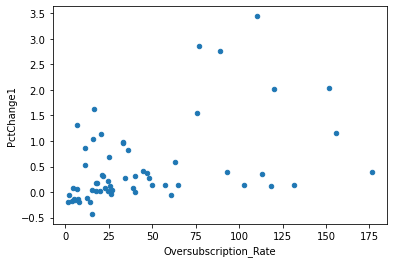

In [325]:
fdf2.query('C0==0').plot.scatter(x="Oversubscription_Rate", y="PctChange1")

In [326]:
xcols

['Oversubscription_Rate', 'Total_Applicants', 'C0', 'Open_Ret']

In [148]:
# fdf.set_index('Date').resample('1Y')['Total_Applicants'].mean().plot()

In [149]:
# fdf.loc[fdf['Oversubscription_Rate'].isna()]

# df.set_index('Stock').loc['FFB']

<AxesSubplot:xlabel='Oversubscription_Rate', ylabel='PctChange1'>

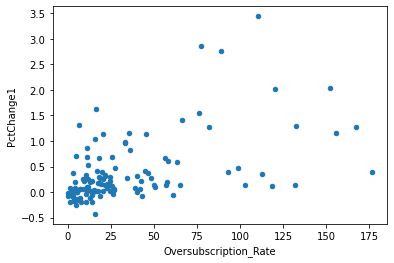

In [226]:
# df = pd.read_excel('IPO_stocks.xlsx') #.dropna()
df = fdf.loc[~fdf['Oversubscription_Rate'].isna()].copy()
df = df.loc[~df['Total_Applicants'].isna()].copy()
df.plot.scatter(x="Oversubscription_Rate", y="PctChange1")
# df.plot.scatter(x="Total_Applicants", y="20d_ret")
# df.plot.scatter(x="Oversubscription_Rate", y="20d_ret")


In [94]:
df[['Oversubscription_Rate', 'Total_Applicants']].corr()

,Oversubscription_Rate,Total_Applicants
Oversubscription_Rate,1.000000,0.592768
Total_Applicants,0.592768,1.000000


<AxesSubplot:xlabel='Oversubscription_Rate', ylabel='Bumiputera_Applicants'>

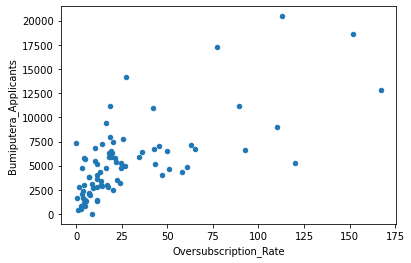

In [95]:
# df.plot.scatter(x= "Oversubscription_Rate",y="Total_Applicants")
df.plot.scatter(x= "Oversubscription_Rate",y="Bumiputera_Applicants")

<AxesSubplot:>

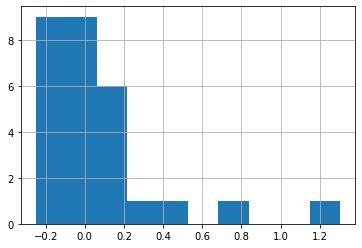

In [96]:
df_ = df.sort_values("Oversubscription_Rate") #.head(20)
# df_.loc[df_['Oversubscription_Rate'] < 10, 'PctChange1'].hist()
df_.loc[df_['Oversubscription_Rate'] < 10, 'PctChange1'].hist()



<AxesSubplot:>

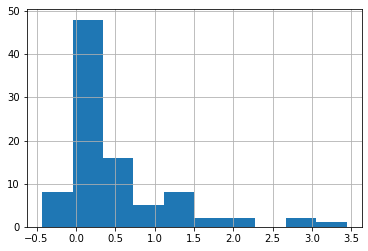

In [97]:
df_.loc[df_['Oversubscription_Rate'] > 10, 'PctChange1'].hist()


In [98]:
df_.loc[df_['Oversubscription_Rate'] > 10, ].sort_values('PctChange1', ascending=True).head(15)

,Date,Stock,StockLongName,Open,Close,PriceChange1,PctChange1,Volume,NumShares,20d_ret,Oversubscription_Rate,Total_Applicants,Bumiputera_Applicants,Bumiputera_Oversubscription_Rate,Public_Applicants,Public_Oversubscription_Rate
Code,,,,,,,,,,,,,,,,
218,2020-03-18,ACO,ACO GROUP BERHAD,0.200,0.160,-0.120,-0.428571,47227300,300000000,-0.125000,15.53,3261.0,NaN,14.79,NaN,16.28
5305,2022-01-25,SENHENG,SENHENG NEW RETAIL BERHAD,0.900,0.855,-0.215,-0.200935,163548600,1500000000,-0.186916,10.44,16548.0,6869.0,5.22,9679.0,15.66
279,2023-06-01,SYNERGY,SYNERGY HOUSE BERHAD,0.380,0.350,-0.080,-0.186047,82379900,500000000,0.011628,14.02,12347.0,7277.0,12.13,5070.0,15.90
226,2020-10-20,ANEKA,ANEKA JARINGAN HOLDINGS BERHAD,0.350,0.290,-0.040,-0.121212,123711200,538100000,-0.196970,12.68,9094.0,NaN,NaN,NaN,NaN
198,2018-03-27,GDB,GDB HOLDINGS BERHAD,0.360,0.325,-0.025,-0.071429,42330300,625000000,-0.100000,43.00,8551.0,5180.0,44.58,3391.0,41.32
5303,2021-12-21,SWIFT,SWIFT HAULAGE BERHAD,1.080,0.960,-0.070,-0.067961,158559100,889804502,-0.228155,18.85,13536.0,6564.0,11.88,6972.0,25.82
5300,2021-07-15,YENHER,YENHER HOLDINGS BERHAD,0.995,0.900,-0.050,-0.052632,61827100,300000000,-0.052632,13.80,10931.0,3007.0,5.05,7924.0,22.56
253,2022-07-13,INFOTEC,INFOLINE TEC GROUP BERHAD,0.330,0.305,-0.015,-0.046875,114936700,363229120,0.078125,60.90,10630.0,4829.0,38.92,5801.0,82.87
250,2022-06-23,YXPM,YX PRECIOUS METALS BHD,0.280,0.270,-0.010,-0.035714,143162800,372150000,-0.321429,26.36,8105.0,NaN,NaN,NaN,NaN


In [99]:
df

,Date,Stock,StockLongName,Open,Close,PriceChange1,PctChange1,Volume,NumShares,20d_ret,Oversubscription_Rate,Total_Applicants,Bumiputera_Applicants,Bumiputera_Oversubscription_Rate,Public_Applicants,Public_Oversubscription_Rate
Code,,,,,,,,,,,,,,,,
247,2022-06-14,UNITRAD,UNITRADE INDUSTRIES BERHAD,0.265,0.300,-0.020,-0.062500,246856800,1562500000,-0.203125,2.35,7169.0,NaN,NaN,NaN,NaN
201,2018-07-20,NOVA,NOVA WELLNESS GROUP BERHAD,0.650,0.760,0.210,0.381818,87920400,317743815,0.090909,2.84,2200.0,824.0,1.62,1376.0,4.05
213,2019-09-25,MTAG,MTAG GROUP BERHAD,0.700,0.440,-0.090,-0.169811,288058800,681617400,-0.037736,3.84,3518.0,1639.0,1.80,1879.0,5.88
189,2017-01-17,MATANG,MATANG BERHAD,0.140,0.140,0.010,0.076923,303914800,1810000256,0.038462,4.21,6389.0,3046.0,3.10,3343.0,5.31
202,2018-07-24,RGTECH,RADIANT GLOBALTECH BERHAD,0.500,0.530,0.300,1.304348,179567100,525200000,0.543478,6.73,2193.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5310,2023-01-17,KITACON,KUMPULAN KITACON BERHAD,0.990,0.750,0.070,0.102941,156697400,500000000,-0.029412,11.46,6876.0,4005.0,11.33,2871.0,11.59
5311,2023-03-10,CEB,CAPE EMS BERHAD,1.420,1.500,0.600,0.666667,253575300,923000000,0.344444,17.82,18526.0,6340.0,8.54,12186.0,27.11
5315,2023-07-10,SKYWLD,SKYWORLD DEVELOPMENT BERHAD,0.800,0.740,-0.060,-0.075000,110509500,1000000000,-0.093750,0.19,3378.0,1644.0,0.23,1734.0,0.15


(array([7.04410376e-03, 6.16986583e-06]), -0.05421068056374869)

C:\Users\BLOOMBERG\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but HuberRegressor was fitted with feature names
  warnings.warn(


array([-0.00095765])

In [107]:
# df['Oversubscription_Rate'].unique()